In [6]:
import torch
from torch.utils import data
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from itertools import islice
import os
import json
from time import time
from collections import Counter
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tnrange, tqdm
from utils import *
%load_ext autoreload
%autoreload 2
text_path = 'data/preprocessed_text.json'

In [2]:
with open('data/preprocessed_text.json', 'r') as f:
    articles = json.load(f)
len(articles.keys())

33375

In [3]:
# original scibert
tokenizer_scibert = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model_scibert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
# bert finetuned on covid
tokenizer_covid = AutoTokenizer.from_pretrained('deepset/covid_bert_base')
model_covid = AutoModel.from_pretrained('deepset/covid_bert_base')
# bert for sentences
model_sent = SentenceTransformer('bert-base-nli-mean-tokens')

In [15]:
def sentence_similarity(first, second):
    return cosine_similarity(sentence_embedding(tokenizer_scibert, model_scibert, first), sentence_embedding(tokenizer_scibert, model_scibert, second))

In [16]:
sentence_similarity("What are the risk factors for the virus?", "Fever was one of the symptoms of the virus.")

0.7844192385673523

## Generate title embeddings OR just load them
Generation will take about 30 minutes per model for the full titles

### Crop paper titles to the first sentence. Drop those that are still too large

In [44]:
# select n papers
n = 2000
max_length = 30
selection = take(n, articles)
selected_papers = {key: articles[key] for key in selection}
titles = [paper_json[1]['title'] for paper_json in selected_papers.items()]
cropped_titles = []
for title in titles:
    dot_index = title.find(".")
    if dot_index == -1:
        cropped_titles.append(title)
    else:
        cropped_titles.append(title[0:dot_index + 1])

# first run removes titles that are too long, 
# second run builds actual embeddings once both tokenizers have removed those that are too long

encoded_scibert, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_scibert, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_covid, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_covid, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_scibert, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_scibert, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_covid, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_covid, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

Dropped 249 titles
Dropped 178 titles
Dropped 0 titles
Dropped 0 titles


#### Generate

In [45]:
batch_size = 32
title_generator = data.DataLoader(encoded_scibert, batch_size=batch_size, num_workers=4)
embeddings_scibert = torch.zeros(encoded_scibert.shape[0], 768)
embeddings_covid = torch.zeros(encoded_scibert.shape[0], 768)
with torch.no_grad():
    cur_index = 0
    t = tqdm(iter(title_generator), leave=False, total=len(title_generator))
    for i, batch in enumerate(t):
        cur_index += batch_size
        output_scibert = model_scibert(batch)
        embeddings_scibert[cur_index - batch_size: cur_index] = output_scibert[0][:, 0, :]

title_generator = data.DataLoader(encoded_covid, batch_size=batch_size, num_workers=4)
with torch.no_grad():
    cur_index = 0
    t = tqdm(iter(title_generator), leave=False, total=len(title_generator))
    for i, batch in enumerate(t):
        cur_index += batch_size
        output_covid = model_covid(batch)
        embeddings_covid[cur_index - batch_size: cur_index] = output_covid[0][:, 0, :]

embeddings_sent = torch.tensor(model_sent.encode(cropped_titles))

In [16]:
#torch.save(embeddings, "embeddings.pt")

#### Load

In [17]:
#embeddings = torch.load("embeddings.pt")

## Similarity search

In [22]:
query = "Risk factors for covid-19 death"
query_embedding_scibert = get_query_embedding(tokenizer_scibert, model_scibert, query, max_length=max_length)
query_embedding_covid = get_query_embedding(tokenizer_covid, model_covid, query, max_length=max_length)
query_embedding_sent = get_query_embedding(None, model_sent, query, max_length=max_length)

In [25]:
n = 20
indices_scibert, titles_scibert = find_top_n_similar(embeddings_scibert, query_embedding_scibert, titles, n=n)
titles_scibert

['Machine intelligence design of 2019-nCoV drugs',
 'Zika virus infection in Collaborative Cross mice 1 2',
 'Title: Viruses are a dominant driver of protein adaptation in mammals',
 'A Generalized Discrete Dynamic Model for Human Epidemics',
 'Similar ratios of introns to intergenic sequence across animal 1 genomes',
 'TALC: Transcription Aware Long Read Correction',
 '(dry-33 iminli@vip',
 'Recombinant vector vaccines and within-host evolution 1',
 'Kin and group selection are both flawed but useful data analysis tools',
 'A Toolkit for Rapid Modular Construction of Biological Circuits in Mammalian Cells',
 'Evolution and variation of 2019-novel coronavirus',
 'Using directed attenuation to enhance vaccine immunity',
 'Epidemic analysis of COVID-19 in China by dynamical modeling',
 'A Combined Evidence Approach to Prioritize Nipah Virus Inhibitors',
 'Mucin 4 Protects Female Mice from Coronavirus Pathogenesis',
 'Transmission potential of COVID-19 in Iran 1',
 'A simple laboratory pa

In [26]:
indices_covid, titles_covid = find_top_n_similar(embeddings_covid, query_embedding_covid, titles, n=n)
titles_covid

['Estimates of the severity of COVID-19 disease',
 'Dynamic profile of severe or critical COVID-19 cases',
 'Correcting under-reported COVID-19 case numbers',
 'Retrospective Analysis of Clinical Features in 101 Death Cases with COVID-19',
 'Epidemic analysis of COVID-19 in China by dynamical modeling',
 'Speed and strength of an epidemic intervention',
 'Financing Vaccines for Global Health Security',
 'Recombinant vector vaccines and within-host evolution 1',
 'High transmissibility of COVID-19 near symptom onset',
 'SKEMPI 2.0: An updated benchmark of changes in protein-protein binding energy, kinetics and thermodynamics upon mutation',
 'TALC: Transcription Aware Long Read Correction',
 'Viral long-term evolutionary strategies favor stability 1 over proliferation',
 '2',
 '(dry-33 iminli@vip',
 'Remote control of neural function by X-ray-induced scintillation',
 'Transmission potential of COVID-19 in Iran 1',
 'Evolutionary origins of epidemic potential among human RNA viruses',
 '

In [27]:
indices_sent, titles_sent = find_top_n_similar(embeddings_sent, query_embedding_sent, titles, n=n)
titles_sent

['Estimation of risk factors for COVID-19 mortality -preliminary results',
 'Estimates of the severity of COVID-19 disease',
 'Risk factors related to hepatic injury in patients with corona virus disease 2019',
 'Potential biochemical markers to identify severe cases among COVID-19 patients',
 'Dynamic profile of severe or critical COVID-19 cases',
 'Impact of the contact and exclusion rates on the spread of COVID-19 pandemic',
 'Estimating the cure rate and case fatality rate of the ongoing epidemic COVID-19',
 'Relations of parameters for describing the epidemic of COVID-19 by the Kermack-McKendrick model',
 'Demographic science aids in understanding the spread and fatality rates of COVID-19',
 'Mechanistic-statistical SIR modelling for early estimation of the actual number of cases and mortality rate from COVID-19',
 'Immunodepletion with Hypoxemia: A Potential High Risk Subtype of Coronavirus Disease 2019',
 'Potential impact of seasonal forcing on a SARS-CoV-2 pandemic',
 'Correct

## Visualization

In [46]:
tsne_scibert = get_tsne_embeddings(embeddings_scibert)
tsne_covid = get_tsne_embeddings(embeddings_covid)
tsne_sent = get_tsne_embeddings(embeddings_sent)

In [47]:
def plot_query_embeddings(query, n=40):
    models = [model_scibert, model_covid, model_sent]
    tokenizers = [tokenizer_scibert, tokenizer_covid, None]
    embeddings = [embeddings_scibert, embeddings_covid, embeddings_sent]
    tsnes = [tsne_scibert, tsne_covid, tsne_sent]
    plot_titles = ["Scibert", "Covid", "Bert Sentence"]
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    for index, cur in enumerate(zip(models, tokenizers, embeddings, plot_titles, tsnes)):
        query_embedding = get_query_embedding(cur[1], cur[0], query)
        similar, _ = find_top_n_similar(cur[2], query_embedding, titles, n=n)
        similar = set(similar[:n].tolist())
        tsne = cur[4]
        for i in range(tsne.shape[0]):
            if i in similar:
                ax[index].scatter(tsne[i, 0], tsne[i, 1], c='r', s=16)
            else:
                ax[index].scatter(tsne[i, 0], tsne[i, 1], c='b', s=4)
        ax[index].set_title(cur[3])

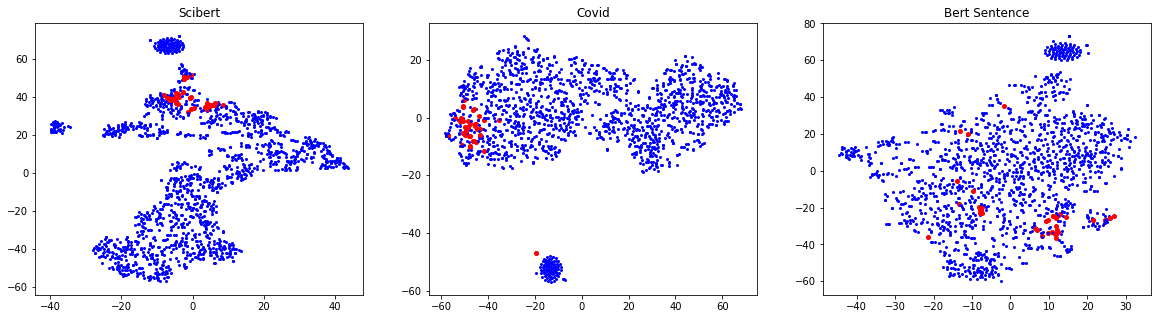

In [48]:
plot_query_embeddings("Risk factors for covid-19 death")

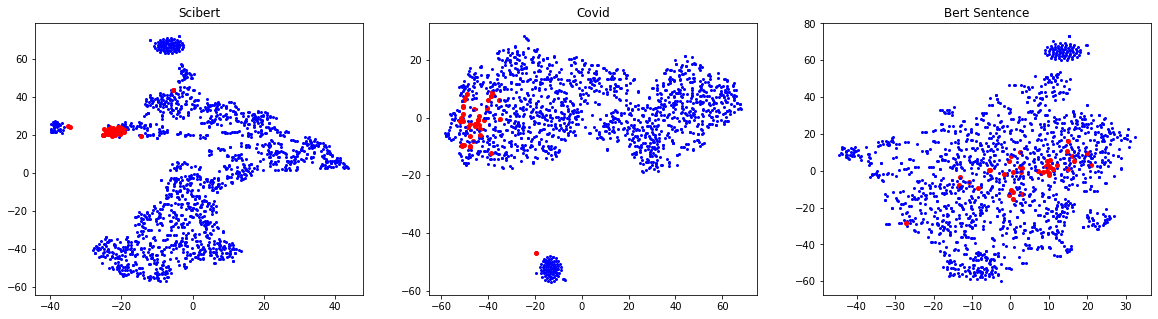

In [49]:
plot_query_embeddings("Asymptomatic carriers of the virus")